# INITIALISATION OF COUNTRIES, ELO, LOCATION.

In [1497]:
import random
import pandas as pd
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np


numtrials = 1000  

In [1498]:
countries = [
    "Brazil",
    "Spain",
    "France",
    "Argentina",
    "Uruguay",
    "Colombia",
    "United Kingdom",
    "Paraguay",
    "Germany",
    "Ecuador",
    "Portugal",
    "Italy",
    "Morocco",
    "Egypt",
    "South Korea",
    "Japan",
    "Mexico",
    "Costa Rica",
    "New Zealand",
    "Australia",
    "Turkey",
    "Switzerland", 
    "Norway",
    "Netherlands"
]
poolsunbalanced = {
    1: ['Mexico', 'Costa Rica', 'Ecuador', 'Colombia'],
    2: ['Brazil', 'Paraguay', 'Uruguay', "Argentina"],
    3: ['South Korea', 'Japan', 'New Zealand', 'Australia'],
    4: ['United Kingdom', 'Germany', 'France', 'Italy', 'Spain', 'Portugal', 'Morocco', 'Egypt', 'Turkey', 'Switzerland', 'Norway', 'Netherlands']
}

pools = {
    1: ['Mexico', 'Costa Rica', 'Ecuador', 'Colombia'],
    2: ['Brazil', 'Paraguay', 'Uruguay', "Argentina"],
    3: ['South Korea', 'Japan', 'New Zealand', 'Australia'],
    4: ['Morocco', 'Spain', 'France', 'Portugal'],
    5: ['Germany', 'Netherlands', 'United Kingdom', 'Norway'],
    6: ['Switzerland', 'Italy', 'Turkey', 'Egypt']
}


elo_ratings = [
    1994,
    2150,
    2031,
    2140,
    1922,
    1953,
    2012,
    1799,
    1988,
    1911,
    1988,
    1914,
    1807,
    1668,
    1745,
    1875,
    1817,
    1653,
    1596,
    1736,
    1837,
    1812,
    1828,
    1967
]
def get_elo(name):
    return countriesratings[name]

countriesratings = {country: elo_ratings[countries.index(country)] for country in countries}
countries_ranked = sorted(countries, key=get_elo, reverse=True)

In [1499]:

import folium
from IPython.display import display

locations = [
    (-14.2350, -51.9253),  # Brazil
    (40.4637, -3.7492),    # Spain
    (46.6034, 1.8883),     # France
    (-38.4161, -63.6167),  # Argentina
    (-32.5228, -55.7659),  # Uruguay
    (4.5709, -74.2973),    # Colombia
    (55.3781, -3.4360),    # United Kingdom
    (-23.4420, -58.4438),  # Paraguay
    (51.1657, 10.4515),    # Germany
    (-1.8312, -78.1834),   # Ecuador
    (39.3999, -8.2245),    # Portugal
    (41.8719, 12.5674),    # Italy
    (31.7915, -7.0926),    # Morocco
    (26.8206, 30.8025),    # Egypt
    (35.9078, 127.7669),   # South Korea
    (36.2048, 138.2529),   # Japan
    (23.6345, -102.5528),  # Mexico
    (9.7489, -83.7534),    # Costa Rica
    (-40.9006, 174.8860),  # New Zealand
    (-25.2744, 133.7751),  # Australia
    (38.9637, 35.2433),    # Turkey
    (46.8182, 8.2275),     # Switzerland
    (60.4720, 8.4689),     # Norway
    (52.1326, 5.2913)      # Netherlands
]

locationdict = {country: locations[countries.index(country)] for country in countries}

games_played_country = {country: 0 for country in countries}
airtime_by_country = {country: 0 for country in countries}


# plot all countries on a map
m = folium.Map(location=[20, 20], zoom_start=2)
for name, rating, location in zip(countries, countriesratings.values(), locations):
    folium.Marker(
        location=location,
        icon=folium.Icon(color="red"),
        tooltip=f"{name} [{rating}]",
    ).add_to(m)
display(m)

# CALCULATING DISTANCE

In [1500]:
from math import radians, sin, cos, sqrt, atan2

# DISTANCE CALCULATIONS
def haversine(pos1, pos2):
    lat1, lon1 = pos1
    lat2, lon2 = pos2
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6371.0 # Radius of Earth in kilometers
    return R * c # Distance in kilometers


def estimate_flight_time(pos1, pos2, speed_kmh=900):
    distance = haversine(pos1, pos2)
    time_hours = distance / speed_kmh
    return time_hours

# ELO SYSTEM + EVALUATION

In [1501]:
# Elo system
def winrate(country1, country2):
    return (1/(1 + 10**((countriesratings[country2]-countriesratings[country1])/400)))

# Evaluation
def evaluate_ranking(ranking, true_ranking):
    """Determines how good a ranking is."""

    loss = 0

    # For each pair of countries in the ranking
    for i, A in enumerate(countries):
        for j, B in enumerate(countries):
            if i >= j:
                continue
            rank_A = ranking.index(A) + 1
            rank_B = ranking.index(B) + 1
            true_A = true_ranking.index(A) + 1
            true_B = true_ranking.index(B) + 1
            if (rank_A < rank_B) == (true_A < true_B):
                continue

            W = (
                1 / true_A
                + 1 / true_B
                + 1 / rank_A
                + 1 / rank_B
            )
            loss += W * (abs(0.5 - winrate(A, B)))
    return loss

# MATCH SIMULATION

In [1502]:
def simulate_match(country1, country2):
    
    global totaltime
    totaltime += 2*estimate_flight_time(locationdict[country1], locationdict[country2])
    
    global total_games_played
    total_games_played += 1
    
    games_played_country[country1] += 1
    games_played_country[country2] += 1
    
    result_country = random.choice([country1, country2])
    airtime_by_country[result_country] += 2*estimate_flight_time(locationdict[country1], locationdict[country2])
    
    percent1 = winrate(country1, country2)
    
    if random.random() < percent1:
        result = 'win'
    else:
        result = 'loss'
    
    if result == 'win':
        return country1, 3, country2, 0  # country1 wins, gets 3 points, country2 gets 0
    elif result == 'loss':
        return country1, 0, country2, 3  # country2 wins, gets 3 points, country1 gets 0
    else:
        return country1, 1, country2, 1  # Draw, both get 1 point each

In [1503]:
def init_standings(teams):
    return {team: {'wins': 0, 'losses': 0, 'draws': 0, 'points': 0} for team in teams}

def sort_standings(standings):
    df = pd.DataFrame(standings).T
    df = df.sort_values(by=['points', 'wins'], ascending=False)
    return df

# TOURNAMENT SIMULATIONS

In [1504]:
def round_robin(teams):
    standings = init_standings(teams)
    for team1, team2 in combinations(teams, 2):
        t1, p1, t2, p2 = simulate_match(team1, team2)
        standings[t1]['points'] += p1
        standings[t2]['points'] += p2
        if p1 == 3:
            standings[t1]['wins'] += 1
            standings[t2]['losses'] += 1
        elif p2 == 3:
            standings[t2]['wins'] += 1
            standings[t1]['losses'] += 1
        else:
            standings[t1]['draws'] += 1
            standings[t2]['draws'] += 1
    return standings

In [1505]:
def simulate_knockout(teams):
    seeded = []
    
    for country in teams:
        seeded.append((country, countriesratings[country]))
    
    seeded.sort(key=lambda x: x[1], reverse=True)
    quarter_finalists = [seeded[0][0], seeded[7][0], seeded[3][0], seeded[4][0], seeded[1][0], seeded[6][0], seeded[2][0], seeded[5][0]]
    semi_finalists = []
    bottom4 = []
    thirdfourth = []
    

    # Quarterfinals
    for i in range(0, 8, 2):
        team1, team2 = quarter_finalists[i], quarter_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < winrate(team1, team2) else 2]
        semi_finalists.append(winner)
        if winner != team1:
            bottom4.append(team1)
        else:
            bottom4.append(team2)
    
    # Sort bottom4 based on the order they appear in the list seeded
    bottom4.sort(key=lambda x: next(i for i, v in enumerate(seeded) if v[0] == x))

    # Semifinals
    finalists = []
    for i in range(0, 4, 2):
        team1, team2 = semi_finalists[i], semi_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < winrate(team1, team2) else 2]
        finalists.append(winner)
        if winner != team1:
            thirdfourth.append(team1)
        else:
            thirdfourth.append(team2)
    thirdfourth.sort(key=lambda x: next(i for i, v in enumerate(seeded) if v[0] == x))
    

    # Final
    final_winner = simulate_match(finalists[0], finalists[1])[0 if random.random() < winrate(team1, team2) else 2]
    if final_winner != finalists[0]:
        second = finalists[0]
    else:
        second = finalists[1]
    
    return {
        bottom4[0]: 5,
        bottom4[1]: 6,
        bottom4[2]: 7,
        bottom4[3]: 8,
        thirdfourth[0]: 3,
        thirdfourth[1]: 4,
        second: 2,
        final_winner: 1
    }

# PLOTTING

In [1506]:
# ---------------------------- PLOTTING ---------------------------------
# Calculate rankings based on countriesratings
def plotgraph(avgstandings, title):
    ratings_ranking = {country: rank for rank, country in enumerate(sorted(countriesratings, key=countriesratings.get, reverse=True), start=1)}


    # Prepare data for the bar graph
    avg_standings_values = [avgstandings[country] for country in countries]

    # Perform max-min normalization for ratings
    min_avg_standing = min(avg_standings_values)
    max_avg_standing = max(avg_standings_values)

    normalized_ratings = {
        country: max_avg_standing - ((max_avg_standing - min_avg_standing) * (countriesratings[country] - min(countriesratings.values())) / 
                                    (max(countriesratings.values()) - min(countriesratings.values())))
        for country in countries
    }

    ratings_ranking_values = [normalized_ratings[country] for country in countries]



    x = np.arange(len(countries))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, avg_standings_values, width, label='Average Standing')
    rects2 = ax.bar(x + width/2, ratings_ranking_values, width, label='Ratings Ranking')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Countries')
    ax.set_ylabel('Rankings')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(countries, rotation=45, ha='right')
    ax.legend()
    fig.tight_layout()

    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.show()

# SPECIFIC MODELS

## Full Single Round Robin

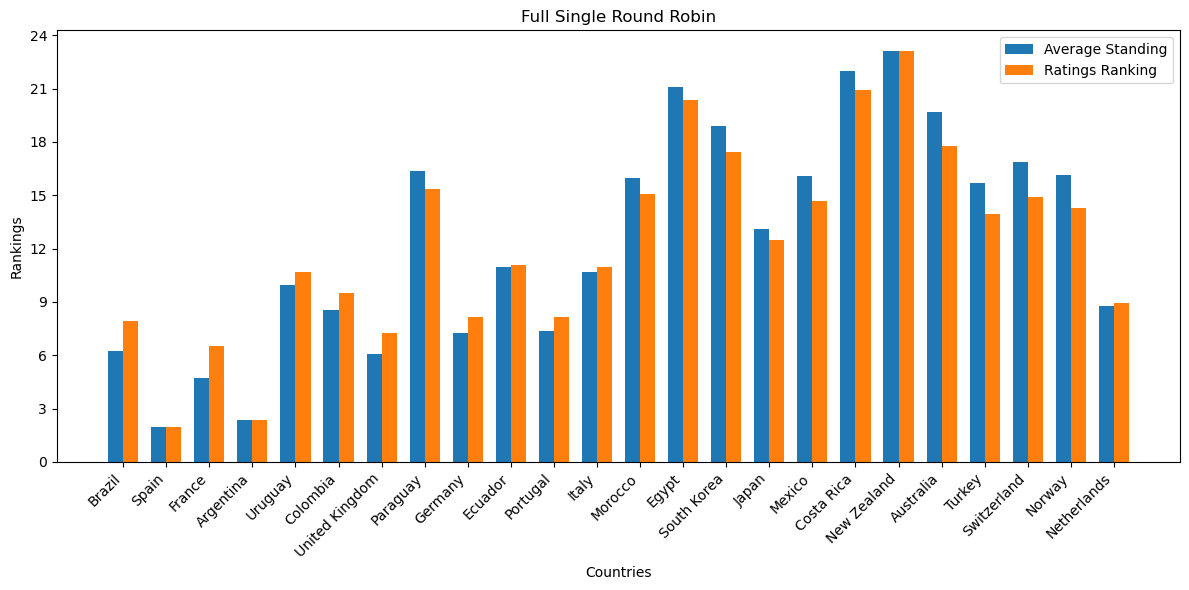

Total games played: 276.0
Total time: 5138.075579818772 hours
{'Brazil': 23.0, 'Spain': 23.0, 'France': 23.0, 'Argentina': 23.0, 'Uruguay': 23.0, 'Colombia': 23.0, 'United Kingdom': 23.0, 'Paraguay': 23.0, 'Germany': 23.0, 'Ecuador': 23.0, 'Portugal': 23.0, 'Italy': 23.0, 'Morocco': 23.0, 'Egypt': 23.0, 'South Korea': 23.0, 'Japan': 23.0, 'Mexico': 23.0, 'Costa Rica': 23.0, 'New Zealand': 23.0, 'Australia': 23.0, 'Turkey': 23.0, 'Switzerland': 23.0, 'Norway': 23.0, 'Netherlands': 23.0}
Average Loss: 1.6491030243291533
Standard Deviation of number of games played: 0.0
Standard Deviation of airtime of countries: 78.69677012269607


In [1507]:
import statistics
avgstandings = {country: 0 for country in countries}

fits = {}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for i in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    standings = round_robin(countries)
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x]['points'], reverse=True)
    
    for j in range(len(sorted_countries)):
        avgstandings[sorted_countries[j]] += (j+1)
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
    total_std += statistics.stdev(airtime_by_country.values())
    
for country, ranking in avgstandings.items():
    avgstandings[country] = ranking/numtrials

airtime_std = total_std/numtrials

# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Full Single Round Robin')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")

std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['fullsinglerobin'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}

## Full Double Round Robin

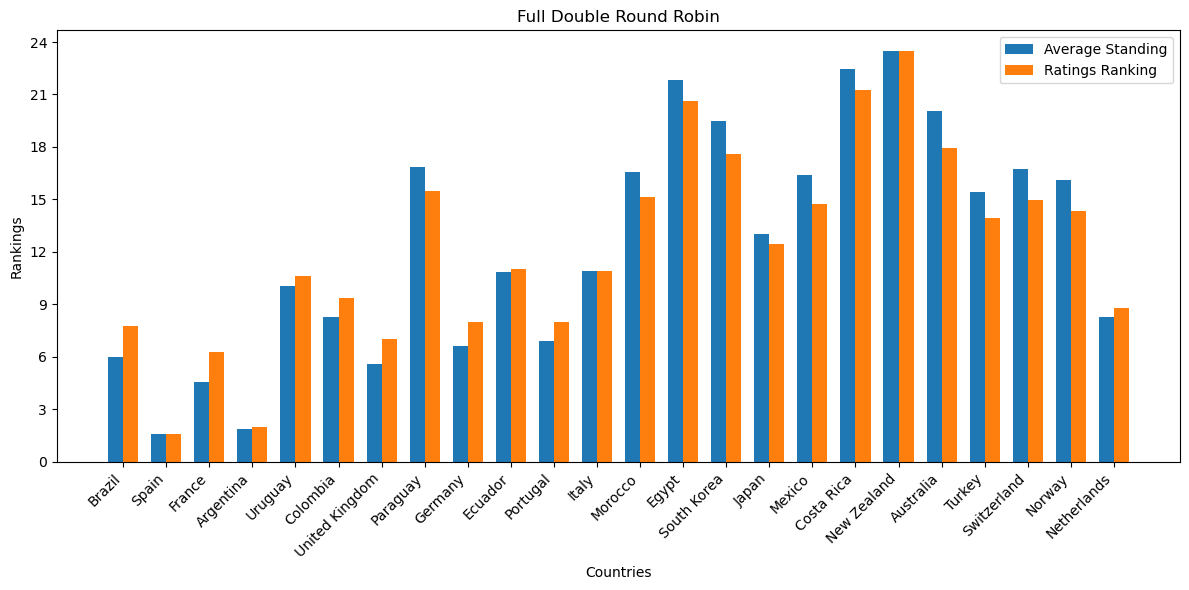

Total games played: 552.0
Total time: 10276.151159639849 hours
{'Brazil': 46.0, 'Spain': 46.0, 'France': 46.0, 'Argentina': 46.0, 'Uruguay': 46.0, 'Colombia': 46.0, 'United Kingdom': 46.0, 'Paraguay': 46.0, 'Germany': 46.0, 'Ecuador': 46.0, 'Portugal': 46.0, 'Italy': 46.0, 'Morocco': 46.0, 'Egypt': 46.0, 'South Korea': 46.0, 'Japan': 46.0, 'Mexico': 46.0, 'Costa Rica': 46.0, 'New Zealand': 46.0, 'Australia': 46.0, 'Turkey': 46.0, 'Switzerland': 46.0, 'Norway': 46.0, 'Netherlands': 46.0}
Average Loss: 0.8689567790796956
Standard Deviation of number of games played: 0.0
Standard Deviation of airtime of countries: 139.1331575059744


In [1508]:
avgstandings = {country: 0 for country in countries}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for i in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    standings = round_robin(countries)
    standings2 = round_robin(countries)
    
    for country in standings:
        standings[country]['points'] += standings2[country]['points']
        standings[country]['wins'] += standings2[country]['wins']
        standings[country]['losses'] += standings2[country]['losses']
        standings[country]['draws'] += standings2[country]['draws']
    
    
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x]['points'], reverse=True)
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
    
    for j in range(len(sorted_countries)):
        avgstandings[sorted_countries[j]] += (j+1)
    
    total_std += statistics.stdev(airtime_by_country.values())
        
    
for country, ranking in avgstandings.items():
    avgstandings[country] = ranking/numtrials
    
airtime_std = total_std/numtrials
    
# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Full Double Round Robin')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")

std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['fulldoublerobin'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}

## Single Round Robin: Unbalanced Groups

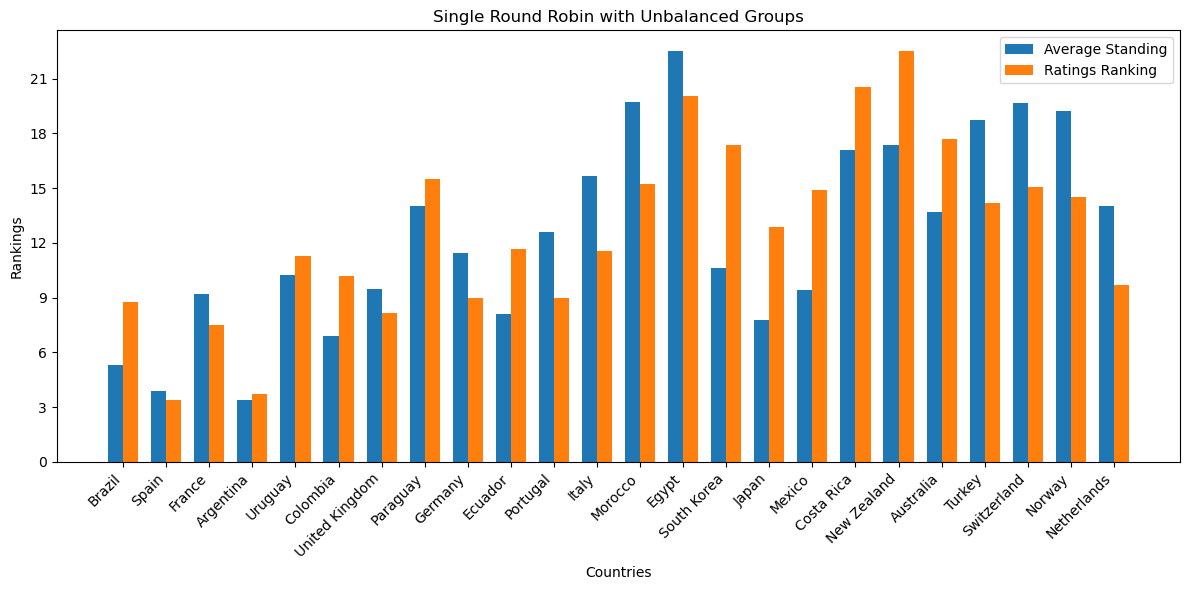

Total games played: 185.0
Total time: 2134.037021875562 hours
{'Brazil': 9.219, 'Spain': 17.209, 'France': 19.614, 'Argentina': 9.241, 'Uruguay': 11.344, 'Colombia': 9.478, 'United Kingdom': 19.639, 'Paraguay': 11.79, 'Germany': 20.264, 'Ecuador': 9.275, 'Portugal': 20.966, 'Italy': 21.381, 'Morocco': 21.962, 'Egypt': 22.0, 'South Korea': 8.464, 'Japan': 7.514, 'Mexico': 8.947, 'Costa Rica': 12.047, 'New Zealand': 11.879, 'Australia': 10.692, 'Turkey': 21.905, 'Switzerland': 21.964, 'Norway': 21.897, 'Netherlands': 21.309}
Average Loss: 6.333682721783786
Standard Deviation of number of games played: 5.7275186270485765
Standard Deviation of airtime of countries: 50.73838101777278


In [1509]:
avgstandings = {country: 0 for country in countries}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for _ in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    pool_results = {}
    direct_to_quarters = []
    qualifier_candidates = []
    bottom8 = []
    ninthtwelve = []

    # ---------- Phase 1: Group Roundrobin ----------
    for pool_name, teams in poolsunbalanced.items():
            
        standings = round_robin(teams)
        df = sort_standings(standings)
        pool_results[pool_name] = df
        direct_to_quarters.append(df.index[0])            # Top 1 to quarters
        qualifier_candidates.extend(df.index[1:3]) 
        
        if len(teams) == 4:
            bottom8.append(df.index[3])
        else:
            bottom8.extend(df.index[3:])

    # ---------- Phase 2: Qualifiers: Next 8 teams run in qualifiers ----------
    qualifier_results = round_robin(qualifier_candidates)
    qualifier_df = sort_standings(qualifier_results)
    qualifier_top4 = list(qualifier_df.index[:4])
    ninthtwelve.extend(qualifier_df.index[4:])

    # ---------- Phase 3: Knockout ----------
    knockout_teams = direct_to_quarters + qualifier_top4
    knockout_results = simulate_knockout(knockout_teams)

    # ---------- Phase 4: Placement Round ----------
    placement_results = round_robin(bottom8)
    placement_df = sort_standings(placement_results)

    sorted_placement = sorted(placement_results.keys(), key=lambda x: placement_results[x]['points'], reverse=True)

    standings = init_standings(countries)

    sorted_knockout = sorted(knockout_results.items(), key=lambda x: x[1])
    for country, position in sorted_knockout:
        standings[country] = position
    
    rank = 9
    for country in ninthtwelve:
        standings[country] = rank
        rank += 1
    
    for country in sorted_placement:
        standings[country] = rank
        rank += 1
        
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x])
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
    
    for country, position in standings.items():
        avgstandings[country] += position
        
    total_std += statistics.stdev(airtime_by_country.values())
        
for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials

airtime_std = total_std/numtrials

# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Single Round Robin with Unbalanced Groups')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")
std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['singlerobinunbalanced'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}


## Double Round Robin: Unbalanced Groups

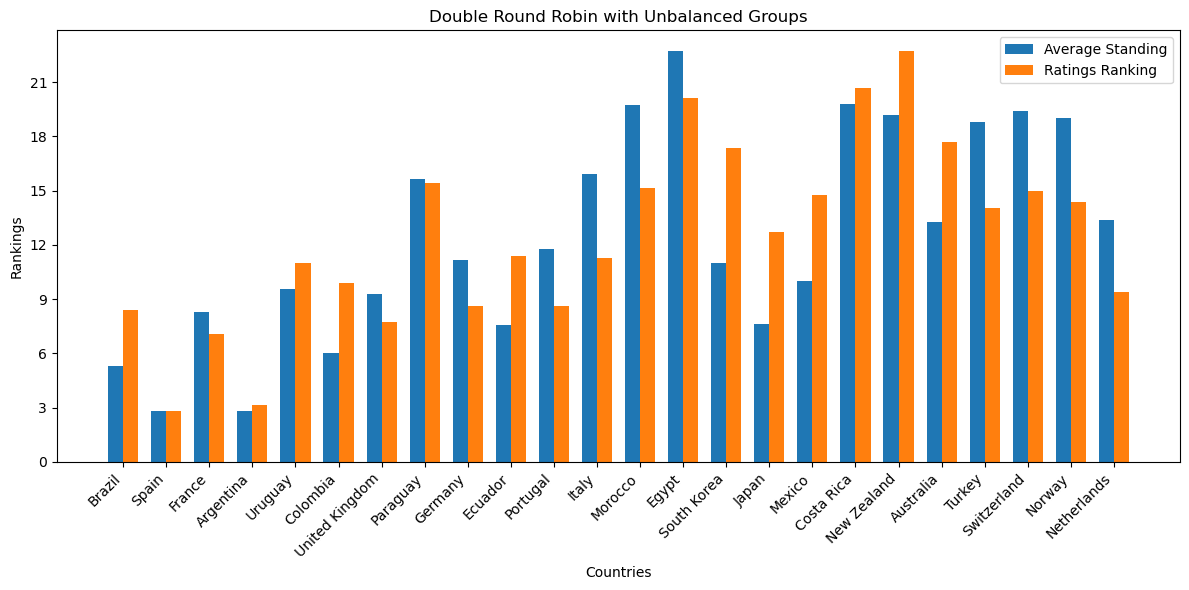

Total games played: 363.0
Total time: 4155.366799067685 hours
{'Brazil': 17.986, 'Spain': 29.629, 'France': 38.518, 'Argentina': 14.15, 'Uruguay': 21.603, 'Colombia': 16.036, 'United Kingdom': 39.465, 'Paraguay': 24.829, 'Germany': 40.783, 'Ecuador': 16.207, 'Portugal': 41.365, 'Italy': 43.541, 'Morocco': 43.984, 'Egypt': 44.0, 'South Korea': 17.498, 'Japan': 12.239, 'Mexico': 18.472, 'Costa Rica': 25.9, 'New Zealand': 25.02, 'Australia': 20.628, 'Turkey': 43.976, 'Switzerland': 43.954, 'Norway': 43.952, 'Netherlands': 42.265}
Average Loss: 4.8980699098084015
Standard Deviation of number of games played: 12.029671732844584
Standard Deviation of airtime of countries: 95.74581061577113


In [1510]:
avgstandings = {country: 0 for country in countries}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for _ in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    pool_results = {}
    direct_to_quarters = []
    qualifier_candidates = []
    bottom8 = []
    ninthtwelve = []

    # ---------- Phase 1: Group Roundrobin ----------
    for pool_name, teams in poolsunbalanced.items():
            
        standings = round_robin(teams)
        standings2 = round_robin(teams)
        
        for country in standings:
            standings[country]['points'] += standings2[country]['points']
            standings[country]['wins'] += standings2[country]['wins']
            standings[country]['losses'] += standings2[country]['losses']
            standings[country]['draws'] += standings2[country]['draws']
        
        df = sort_standings(standings)
        pool_results[pool_name] = df
        direct_to_quarters.append(df.index[0])      # Top 1 to quarters
        qualifier_candidates.extend(df.index[1:3]) 
        
        if len(teams) == 4:
            bottom8.append(df.index[3])
        else:
            bottom8.extend(df.index[3:])
            

    # ---------- Phase 2: Qualifiers: Next 8 teams run in qualifiers ----------
    qualifier_results = round_robin(qualifier_candidates)
    qualifer2 = round_robin(qualifier_candidates)
    for country in qualifier_results:
        qualifier_results[country]['points'] += qualifer2[country]['points']
        qualifier_results[country]['wins'] += qualifer2[country]['wins']
        qualifier_results[country]['losses'] += qualifer2[country]['losses']
        qualifier_results[country]['draws'] += qualifer2[country]['draws']
    qualifier_df = sort_standings(qualifier_results)
    qualifier_top4 = list(qualifier_df.index[:4])
    ninthtwelve.extend(qualifier_df.index[4:])

    # ---------- Phase 3: Knockout ----------
    knockout_teams = direct_to_quarters + qualifier_top4
    knockout_results = simulate_knockout(knockout_teams)
    
    # ---------- Phase 4: Placement Round ----------
    placement_results = round_robin(bottom8)
    placement2 = round_robin(bottom8)
    for country in placement_results:
        placement_results[country]['points'] += placement2[country]['points']
        placement_results[country]['wins'] += placement2[country]['wins']
        placement_results[country]['losses'] += placement2[country]['losses']
        placement_results[country]['draws'] += placement2[country]['draws']
    placement_df = sort_standings(placement_results)
    
    
    sorted_placement = sorted(placement_results.keys(), key=lambda x: placement_results[x]['points'], reverse=True)
    standings = init_standings(countries)

    sorted_knockout = sorted(knockout_results.items(), key=lambda x: x[1])
    for country, position in sorted_knockout:
        standings[country] = position
        
            
    rank = 9
    for country in ninthtwelve:
        standings[country] = rank
        rank += 1
        
    for country in sorted_placement:
        standings[country] = rank
        rank += 1



        
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x])
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
        
    for country, position in standings.items():
        avgstandings[country] += position
    
    total_std += statistics.stdev(airtime_by_country.values())
        
for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials
    
airtime_std = total_std/numtrials
    
# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Double Round Robin with Unbalanced Groups')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")
std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['doublerobinunbalanced'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}

## Single Round Robin, 5 groups of 4

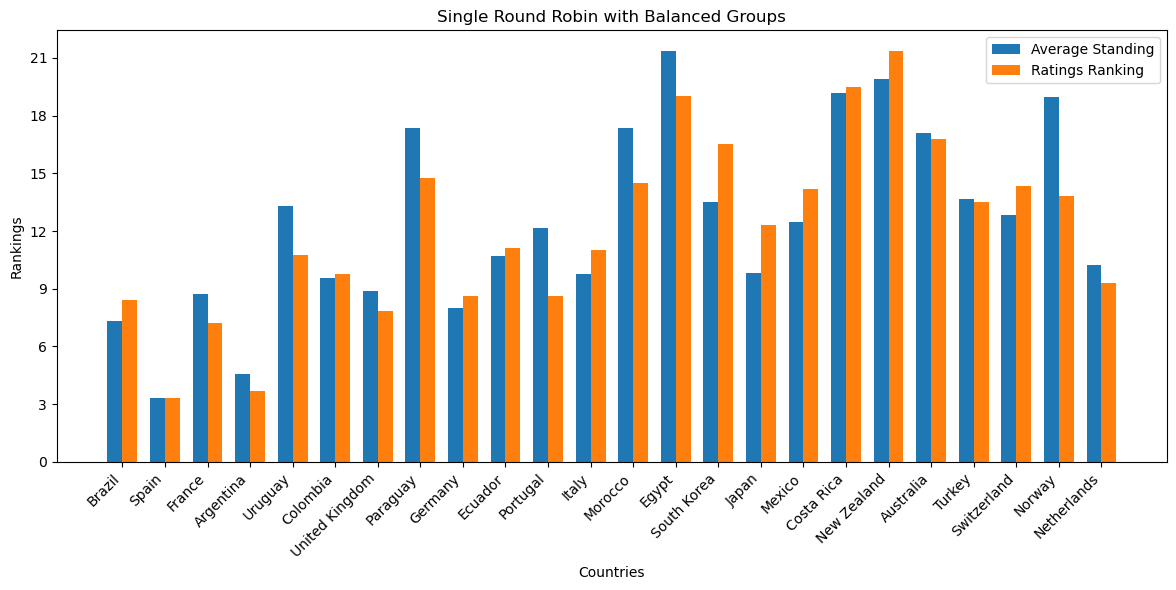

Total games played: 124.0
Total time: 1900.3068044923027 hours
{'Brazil': 10.559, 'Spain': 8.998, 'France': 12.02, 'Argentina': 10.396, 'Uruguay': 11.105, 'Colombia': 10.28, 'United Kingdom': 11.181, 'Paraguay': 10.503, 'Germany': 9.615, 'Ecuador': 10.345, 'Portugal': 11.616, 'Italy': 9.519, 'Morocco': 10.042, 'Egypt': 9.355, 'South Korea': 9.934, 'Japan': 8.872, 'Mexico': 10.138, 'Costa Rica': 9.98, 'New Zealand': 10.541, 'Australia': 10.891, 'Turkey': 11.321, 'Switzerland': 10.166, 'Norway': 9.63, 'Netherlands': 10.993}
Average Loss: 5.561804189683126
Standard Deviation of number of games played: 0.7978334067507677
Standard Deviation of airtime of countries: 57.752896562888665
10.333333333333334


In [1511]:

avgstandings = {country: 0 for country in countries}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for _ in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    pool_results = {}
    direct_to_quarters = []
    qualifier_candidates = []
    bottom4 = []
    ninth16 = []

    # ---------- Phase 1: Group Roundrobin ----------
    for pool_name, teams in pools.items():
            
        standings = round_robin(teams)
        df = sort_standings(standings)
        pool_results[pool_name] = df
        direct_to_quarters.append(df.index[0])      # Top 1 to quarters
        qualifier_candidates.extend(df.index[1:3]) 
        
        bottom4.append(df.index[3])
            

    # ---------- Phase 2: Qualifiers: Next 10 teams run in qualifiers ----------
    qualifier_results = round_robin(qualifier_candidates)
    qualifier_df = sort_standings(qualifier_results)
    qualifier_top4 = list(qualifier_df.index[:2])
    ninth16.extend(qualifier_df.index[2:])

    # ---------- Phase 3: Knockout ----------
    knockout_teams = direct_to_quarters + qualifier_top4
    knockout_results = simulate_knockout(knockout_teams)
    
    # ---------- Phase 4: Placement Round ----------
    placement_results = round_robin(bottom4)
    placement_df = sort_standings(placement_results)
    
    
    sorted_placement = sorted(placement_results.keys(), key=lambda x: placement_results[x]['points'], reverse=True)
    standings = init_standings(countries)

    sorted_knockout = sorted(knockout_results.items(), key=lambda x: x[1])
    for country, position in sorted_knockout:
        standings[country] = position
    
    rank = 9
    for country in ninth16:
        standings[country] = rank
        rank += 1
        
    for country in sorted_placement:
        standings[country] = rank
        rank += 1
        
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x])
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
        
    for country, position in standings.items():
        avgstandings[country] += position

    # Calculate standard deviation of flight times
    total_std += statistics.stdev(airtime_by_country.values())
        
for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials

airtime_std = total_std/numtrials

# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Single Round Robin with Balanced Groups')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

avg_games_played = sum(games_played_country.values())/(numtrials*len(countries))

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")
std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
print(avg_games_played)
fits['singlerobinbalanced'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}

## Double Round Robin: 5 Groups of 4

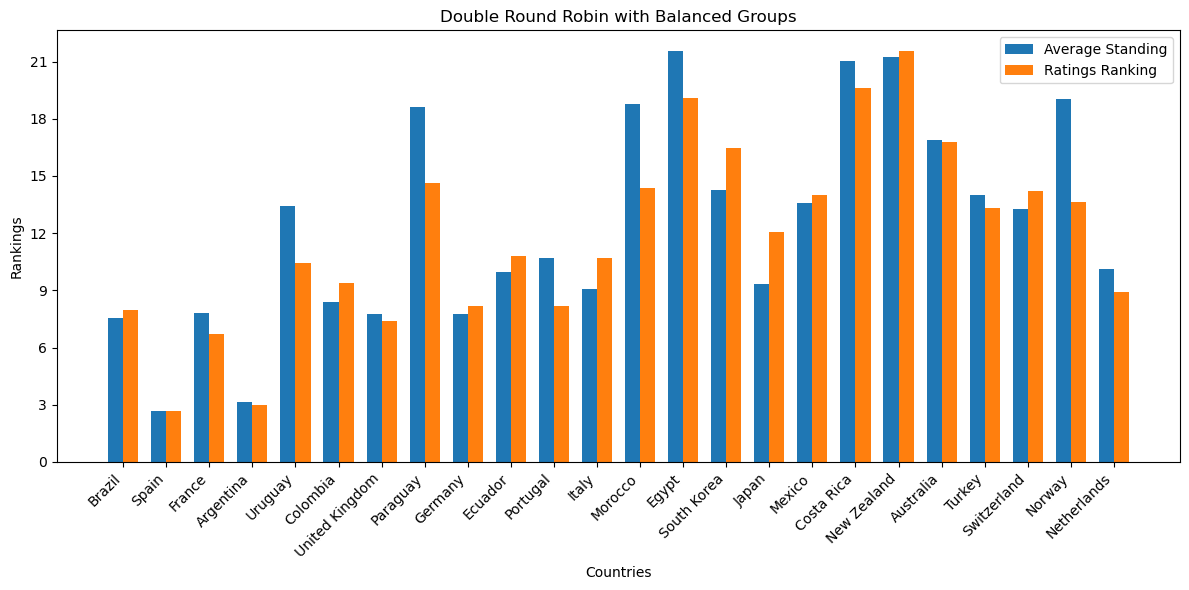

Total games played: 241.0
Total time: 3670.2118027807533 hours
{'Brazil': 22.177, 'Spain': 14.066, 'France': 24.148, 'Argentina': 16.362, 'Uruguay': 22.767, 'Colombia': 19.773, 'United Kingdom': 21.186, 'Paraguay': 20.119, 'Germany': 18.763, 'Ecuador': 18.897, 'Portugal': 24.044, 'Italy': 17.036, 'Morocco': 19.689, 'Egypt': 18.222, 'South Korea': 21.168, 'Japan': 15.299, 'Mexico': 22.559, 'Costa Rica': 18.437, 'New Zealand': 19.774, 'Australia': 22.971, 'Turkey': 23.718, 'Switzerland': 20.373, 'Norway': 18.359, 'Netherlands': 22.093}
Average Loss: 4.067011546020349
Standard Deviation of number of games played: 2.7415302877846486
Standard Deviation of airtime of countries: 107.98000856092048


In [1512]:
avgstandings = {country: 0 for country in countries}

loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for _ in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    sorted_countries = []
    
    pool_results = {}
    direct_to_quarters = []
    qualifier_candidates = []
    bottom4 = []
    ninth16 = []

    # ---------- Phase 1: Group Roundrobin ----------
    for pool_name, teams in pools.items():
            
        standings = round_robin(teams)
        standings2 = round_robin(teams)
        
        for country in standings:
            standings[country]['points'] += standings2[country]['points']
            standings[country]['wins'] += standings2[country]['wins']
            standings[country]['losses'] += standings2[country]['losses']
            standings[country]['draws'] += standings2[country]['draws']
        
        df = sort_standings(standings)
        pool_results[pool_name] = df
        direct_to_quarters.append(df.index[0])      # Top 1 to quarters
        qualifier_candidates.extend(df.index[1:3]) 
        
        bottom4.append(df.index[3])
            

    # ---------- Phase 2: Qualifiers: Next 10 teams run in qualifiers ----------
    qualifier_results = round_robin(qualifier_candidates)
    qualifer2 = round_robin(qualifier_candidates)
    for country in qualifier_results:
        qualifier_results[country]['points'] += qualifer2[country]['points']
        qualifier_results[country]['wins'] += qualifer2[country]['wins']
        qualifier_results[country]['losses'] += qualifer2[country]['losses']
        qualifier_results[country]['draws'] += qualifer2[country]['draws']
    qualifier_df = sort_standings(qualifier_results)
    qualifier_top4 = list(qualifier_df.index[:2])
    ninth16.extend(qualifier_df.index[2:])

    # ---------- Phase 3: Knockout ----------
    knockout_teams = direct_to_quarters + qualifier_top4
    knockout_results = simulate_knockout(knockout_teams)
    
    # ---------- Phase 4: Placement Round ----------
    placement_results = round_robin(bottom4)
    placement2 = round_robin(bottom4)
    for country in placement_results:
        placement_results[country]['points'] += placement2[country]['points']
        placement_results[country]['wins'] += placement2[country]['wins']
        placement_results[country]['losses'] += placement2[country]['losses']
        placement_results[country]['draws'] += placement2[country]['draws']
    placement_df = sort_standings(placement_results)
    
    
    sorted_placement = sorted(placement_results.keys(), key=lambda x: placement_results[x]['points'], reverse=True)
    standings = init_standings(countries)

    sorted_knockout = sorted(knockout_results.items(), key=lambda x: x[1])
    for country, position in sorted_knockout:
        standings[country] = position
    
    rank = 9
    for country in ninth16:
        standings[country] = rank
        rank += 1
        
    for country in sorted_placement:
        standings[country] = rank
        rank += 1
        
    sorted_countries = sorted(standings.keys(), key=lambda x: standings[x])
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
        
    for country, position in standings.items():
        avgstandings[country] += position
        
    total_std += statistics.stdev(airtime_by_country.values())
        
for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials
    
airtime_std = total_std/numtrials
    
# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Double Round Robin with Balanced Groups')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")
std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['doublerobinbalanced'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}

## Random Elimination

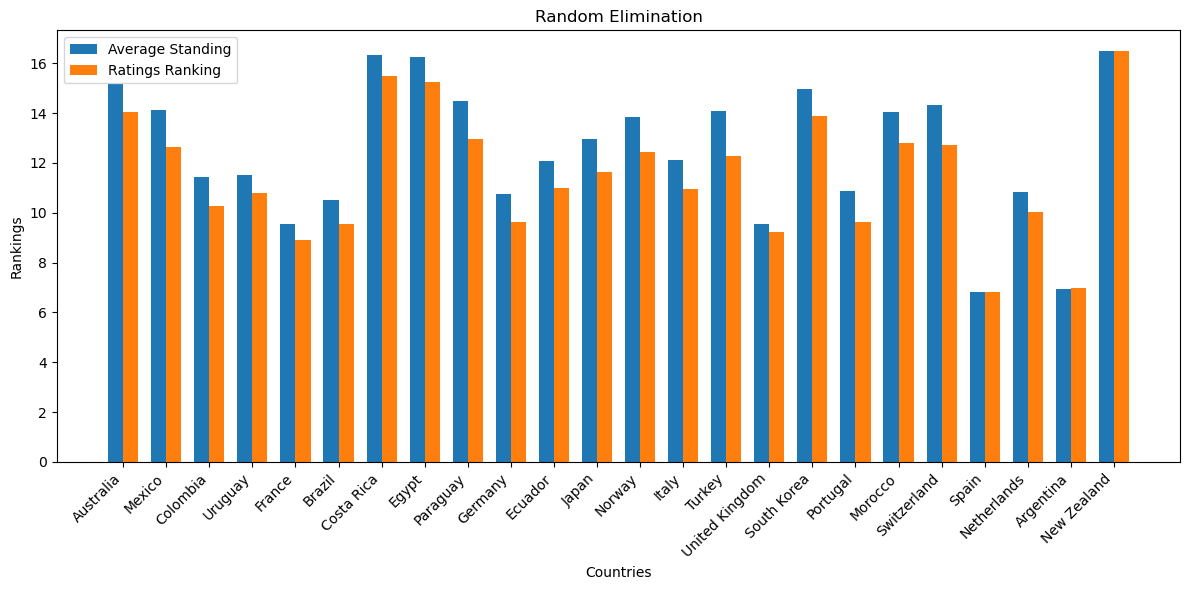

Total games played: 23.0
Total time: 401.61463976943526 hours
{'Brazil': 2.275, 'Spain': 3.113, 'France': 2.472, 'Argentina': 3.053, 'Uruguay': 2.031, 'Colombia': 2.079, 'United Kingdom': 2.467, 'Paraguay': 1.563, 'Germany': 2.228, 'Ecuador': 1.936, 'Portugal': 2.181, 'Italy': 1.915, 'Morocco': 1.58, 'Egypt': 1.304, 'South Korea': 1.469, 'Japan': 1.785, 'Mexico': 1.604, 'Costa Rica': 1.284, 'New Zealand': 1.223, 'Australia': 1.423, 'Turkey': 1.611, 'Switzerland': 1.594, 'Norway': 1.638, 'Netherlands': 2.172}
Average Loss: 9.704190189164851
Standard Deviation of number of games played: 0.5134522260208803
Standard Deviation of airtime of countries: 18.959244837597687


In [1513]:
import random

def simulate_random_elimination(countries):
    # Initialize standings
    standings = {country: 0 for country in countries}
    eliminated = []

    # Random elimination rounds
    round_number = 1
    while len(countries) > 1:
        random.shuffle(countries)
        next_round = []

        for i in range(0, len(countries), 2):
            if i + 1 < len(countries):
                country1 = countries[i]
                country2 = countries[i + 1]
                t1, p1, t2, p2 = simulate_match(country1, country2)
                
                if p1 == 3:
                    # country1 won
                    winner = t1
                else:
                    winner = t2
        
                loser = country1 if winner == country2 else country2
                next_round.append(winner)
                eliminated.append(loser)
            else:
                # If odd number of countries, the last one automatically advances
                next_round.append(countries[i])

        countries = next_round
        round_number += 1

    # Final winner
    winner = countries[0]
    standings[winner] = 1

    # Assign rankings to eliminated countries
    rank = 2
    for country in reversed(eliminated):
        standings[country] = rank
        rank += 1

    return standings

# Simulate the random elimination system
avgstandings = {country: 0 for country in countries}
loss_total = 0
totaltime = 0
total_games_played = 0
games_played_country = {country: 0 for country in countries}
total_std = 0

for _ in range(numtrials):
    airtime_by_country = {country: 0 for country in countries}
    random_elimination_standings = simulate_random_elimination(countries)
    
    sorted_countries = sorted(random_elimination_standings.keys(), key=lambda x: random_elimination_standings[x])
    
    loss_total += evaluate_ranking(sorted_countries, countries_ranked)
    
    for country, position in random_elimination_standings.items():
        avgstandings[country] += position
        
    total_std += statistics.stdev(airtime_by_country.values())
    
for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials

airtime_std = total_std/numtrials    

# Plotting + Showing relevant data    
plotgraph(avgstandings, 'Random Elimination')
print(f"Total games played: {total_games_played/numtrials}")
print(f"Total time: {(totaltime/numtrials)} hours")

for country, num in games_played_country.items():
    games_played_country[country] = num/numtrials
print(games_played_country)
print(f"Average Loss: {loss_total/numtrials}")
std_dev = statistics.stdev(games_played_country.values())
print(f"Standard Deviation of number of games played: {std_dev}")
print(f"Standard Deviation of airtime of countries: {airtime_std}")
fits['elimination'] = {'games': total_games_played/numtrials, 'time': totaltime/numtrials, 'deviation': std_dev, 'loss': loss_total/numtrials, 'airtimedev': airtime_std/(totaltime/numtrials)}
    


# ANALYSIS

In [1514]:
# Min-max normalization for each metric in the fits dictionary


normalized_fits = {}
metrics = ['games', 'time', 'deviation', 'loss', 'airtimedev']



# Extract min and max for each metric
min_max = {metric: (min(fit[metric] for fit in fits.values()), max(fit[metric] for fit in fits.values())) for metric in metrics}

# Normalize each value
for key, values in fits.items():
    normalized_fits[key] = {
        metric: (values[metric] - min_max[metric][0]) / (min_max[metric][1] - min_max[metric][0])
        for metric in metrics
    }
    
print(normalized_fits)

# weights = [0.1968708483,	0.2797103175,	0.0807229401,	0.442695894]
# weights = [0.2214610339,	0.3101115125,	0.07330141242,	0.3951260413]

weights = [0.2104155797,	0.3404226382,	0.07273615894,	0.2821103089,	0.0943153142]



# Calculate the overall index for each round format
overall_index = {}
for key, values in normalized_fits.items():
    overall_index[key] = 1 - sum(values[metric] * weight for metric, weight in zip(metrics, weights))
    
for mode, index in overall_index.items():
    print(mode, index)



{'fullsinglerobin': {'games': 0.4782608695652174, 'time': 0.4796641270725175, 'deviation': 0.0, 'loss': 0.08829944937945206, 'airtimedev': 0.052778905840111}, 'fulldoublerobin': {'games': 1.0, 'time': 1.0, 'deviation': 0.0, 'loss': 0.0, 'airtimedev': 0.0}, 'singlerobinunbalanced': {'games': 0.30623818525519847, 'time': 0.17544341231813704, 'deviation': 0.4761159534728405, 'loss': 0.6185151754413493, 'airtimedev': 0.30403679150804386}, 'doublerobinunbalanced': {'games': 0.6427221172022685, 'time': 0.38014464291509975, 'deviation': 1.0, 'loss': 0.45602792181241, 'airtimedev': 0.2822271089255112}, 'singlerobinbalanced': {'games': 0.19092627599243855, 'time': 0.15177341860117352, 'deviation': 0.06632212619505196, 'loss': 0.5311514923020239, 'airtimedev': 0.500530629750965}, 'doublerobinbalanced': {'games': 0.4120982986767486, 'time': 0.33101271704590474, 'deviation': 0.22789734821270768, 'loss': 0.3619660758809347, 'airtimedev': 0.47169902826252963}, 'elimination': {'games': 0.0, 'time': 0